In [1]:
# import necessary libraries
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import math
import re
import time
import os
import sys
import csv
import string
import warnings
warnings.filterwarnings('ignore') 

import statsmodels.formula.api as sm

from sklearn import tree, svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RepeatedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

pd.set_option("display.max_rows", 100, "display.max_columns", 100)

Here we will do actual analysis. Since we have already converted the dataframes to csv files, we won't have to run all the web-scraping algorithms.

In [2]:
all_nba_players = pd.read_csv('csv_files/all_nba_players.csv')

In [3]:
display(all_nba_players.head(500))
display(all_nba_players.dtypes)

,Player,Debut,Last Active,YOE,Retired,Position,Team,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
0,Alaa Abdelnaby,1990,1995,5,1,PF,POR,256,5.7,1465,3.3,846,0.3,85,0.3,71,0.3,69,50.2,0.0,70.1,50.2,13.0,1.0,4.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Zaid Abdul-Aziz,1968,1978,10,1,C,HOU,505,9.0,4557,8.0,4065,1.2,601,0.6,131,1.0,205,42.8,0.0,72.8,0.0,15.1,1.8,17.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kareem Abdul-Jabbar,1969,1989,20,1,C,LAL,1560,24.6,38387,11.2,17440,3.6,5660,0.9,1160,2.6,3189,55.9,5.6,72.1,55.9,24.6,13.7,273.4,1,1995,19,2,1,0,0,4,6,15,1,1,11,0,0,0,0,6,2,1
3,Mahmoud Abdul-Rauf,1990,2001,9,1,PG,DEN,586,14.6,8553,1.9,1087,3.5,2079,0.8,487,0.1,46,44.2,35.4,90.5,47.2,15.4,2.8,25.2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,Tariq Abdul-Wahad,1997,2003,6,1,SG,DEN,236,7.8,1830,3.3,776,1.1,266,0.8,184,0.4,83,41.7,23.7,70.3,42.2,11.4,0.6,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Ernest Brown,2001,2002,1,1,C,MIA,3,1.0,3,2.0,6,0.0,0,0.0,0,0.3,1,16.7,0.0,25.0,16.7,-9.7,-0.2,-0.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
496,Fred Brown,1971,1984,13,1,SG,OKC,963,14.6,14018,2.7,2637,3.3,3160,1.4,1149,0.2,166,47.8,37.3,85.8,48.2,17.7,4.9,63.2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
497,George Brown,1957,1958,1,1,NaN,LAL,1,1.0,1,1.0,1,0.0,0,0.0,0,0.0,0,0.0,0.0,50.0,0.0,-7.2,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
498,Gerald Brown,1998,1999,1,1,SG,PHO,33,2.4,80,0.7,22,0.9,31,0.2,5,0.0,1,37.1,30.0,78.6,38.8,7.3,-0.3,-0.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Player                   object
Debut                     int64
Last Active               int64
YOE                       int64
Retired                   int64
Position                 object
Team                     object
Total Games               int64
Career PPG              float64
Total PTS                 int64
Career RPG              float64
Total RBS                 int64
Career APG              float64
Total AST                 int64
Career SPG              float64
Total STL                 int64
Career BPG              float64
Total BLK                 int64
Career FG%              float64
Career FG3%             float64
Career FT%              float64
Career eFG%             float64
PER                     float64
Avg WS                  float64
Total WS                float64
Hall of Fame              int64
Year Inducted             int64
All-Stars                 int64
Scoring Champs            int64
Rebound Champs            int64
Assist Champs             int64
Steal Ch

In [4]:
display(all_nba_players.describe())

,Debut,Last Active,YOE,Retired,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
count,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.00000,4397.000000,4397.000000,4397.000000
mean,1991.204003,1996.766432,5.268820,0.807824,290.551740,6.455788,2992.915624,2.942188,1291.967478,1.456902,667.068228,0.459177,196.698658,0.269343,122.587901,41.443484,17.307619,67.131385,36.414373,11.044485,1.508710,14.771139,0.029566,58.657721,0.411417,0.017057,0.016375,0.016602,0.010917,0.010917,0.209234,0.203775,0.112349,0.019331,0.126450,0.008187,0.008870,0.017967,0.00887,0.016830,0.012054,0.017285
std,20.994117,21.249146,4.500436,0.394056,320.393188,4.823565,4725.649713,2.276650,2129.285266,1.392988,1213.283236,0.414007,336.844494,0.368878,291.804208,10.820365,17.165869,20.159278,20.840834,6.664832,2.081922,27.272577,0.169405,337.447671,1.663636,0.254049,0.269305,0.270555,0.157809,0.168947,0.717566,1.171334,0.315832,0.137702,0.834822,0.090123,0.113524,0.180725,0.14040,0.217916,0.169542,0.130344
min,1946.000000,1950.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-48.600000,-2.000000,-10.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1976.000000,1982.000000,1.000000,1.000000,34.000000,2.900000,97.000000,1.300000,42.000000,0.500000,19.000000,0.100000,2.000000,0.000000,0.000000,37.600000,0.000000,62.300000,30.000000,8.700000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1993.000000,2000.000000,3.000000,1.000000,143.000000,5.200000,761.000000,2.400000,351.000000,1.000000,152.000000,0.400000,36.000000,0.200000,15.000000,42.700000,17.600000,71.800000,45.300000,11.600000,0.700000,2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,2010.000000,2016.000000,8.000000,1.000000,490.000000,8.700000,3948.000000,3.900000,1713.000000,2.000000,752.000000,0.700000,250.000000,0.400000,110.000000,46.900000,32.700000,78.400000,49.800000,14.200000,2.400000,17.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,2021.000000,2022.000000,22.000000,1.000000,1611.000000,30.100000,38387.000000,22.900000,23924.000000,11.200000,15806.000000,2.700000,3265.000000,3.500000,3830.000000,100.000000,100.000000,100.000000,150.000000,88.300000,17.900000,273.400000,1.000000,2022.000000,19.000000,10.000000,11.000000,9.000000,6.000000,4.000000,11.000000,17.000000,1.000000,1.000000,15.000000,1.000000,3.000000,4.000000,4.00000,6.000000,6.000000,1.000000


In [5]:
retired_csv = pd.read_csv('csv_files/retired_players.csv')

In [6]:
hof_players = pd.read_csv('csv_files/hall_of_famers.csv')

In [7]:
hof_players.describe()

,Debut,Last Active,YOE,Retired,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
count,130.000000,130.000000,130.000000,130.0,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.0,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,1970.807692,1984.461538,13.323077,1.0,930.823077,18.253077,17215.707692,7.743846,7079.669231,3.862308,3671.153846,0.876923,745.069231,0.626154,570.176923,46.505385,14.721538,76.660000,31.221538,19.281538,7.689231,104.695385,1.0,1983.984615,7.538462,0.461538,0.400000,0.369231,0.100000,0.115385,1.676923,4.523077,0.538462,0.276923,1.853846,0.007692,0.038462,0.469231,0.153846,0.461538,0.292308,0.484615
std,15.446881,17.638996,3.322965,0.0,265.040774,4.575824,7096.014110,3.994143,4402.044790,1.995975,2422.608599,0.688503,754.790275,0.768322,855.176816,5.049819,15.264825,7.673811,24.516089,3.218787,2.596546,48.547574,0.0,176.093482,3.662409,1.306833,1.378686,1.376088,0.463388,0.551736,2.164604,3.943821,0.500447,0.449209,3.362150,0.087706,0.229723,0.827703,0.615832,1.086591,0.811221,0.501697
min,1946.000000,1954.000000,3.000000,1.0,202.000000,5.700000,3315.000000,1.900000,980.000000,1.000000,587.000000,0.000000,0.000000,0.000000,0.000000,30.200000,0.000000,41.400000,0.000000,10.900000,2.200000,16.100000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1958.000000,1971.250000,11.000000,1.0,766.250000,15.600000,12006.000000,4.400000,3832.250000,2.500000,2057.250000,0.000000,0.000000,0.000000,0.000000,43.650000,0.000000,73.700000,0.000000,17.300000,5.925000,74.925000,1.0,1987.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1970.000000,1983.000000,13.000000,1.0,912.500000,18.500000,16984.500000,6.750000,5727.000000,3.450000,3038.000000,1.000000,603.500000,0.300000,200.000000,46.500000,14.300000,78.000000,46.850000,18.950000,7.150000,93.300000,1.0,1999.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1983.750000,1999.000000,15.000000,1.0,1073.750000,20.775000,21739.750000,10.250000,9345.500000,4.700000,4594.000000,1.300000,1208.000000,0.800000,750.250000,50.375000,27.475000,80.925000,50.700000,21.350000,8.875000,129.925000,1.0,2014.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,2003.000000,2018.000000,21.000000,1.0,1611.000000,30.100000,38387.000000,22.900000,23924.000000,11.200000,15806.000000,2.600000,3265.000000,3.100000,3830.000000,58.200000,66.700000,90.400000,58.200000,27.900000,17.700000,273.400000,1.0,2022.000000,19.000000,10.000000,11.000000,9.000000,3.000000,4.000000,11.000000,15.000000,1.000000,1.000000,15.000000,1.000000,2.000000,4.000000,4.000000,6.000000,6.000000,1.000000


In [8]:
retired_non_hof_csv = pd.read_csv('csv_files/retired_non_hof.csv')

In [9]:
retired_non_hof_csv.describe()

,Debut,Last Active,YOE,Retired,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
count,3422.000000,3422.000000,3422.000000,3422.0,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.0,3422.0,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000
mean,1985.715371,1991.145821,5.105786,1.0,277.603448,5.759030,2519.984804,2.699182,1119.217709,1.324605,571.917884,0.414874,175.957919,0.233402,105.154296,40.868147,14.536324,66.199825,33.553857,10.461222,1.217943,11.664407,0.0,0.0,0.159264,0.000584,0.001753,0.003799,0.006137,0.006137,0.177089,0.042957,0.084161,0.009643,0.061952,0.007013,0.007890,0.001461,0.002046,0.000292,0.001461,0.000584
std,18.670067,19.512146,4.391260,0.0,307.914216,4.023419,3809.106059,1.990017,1755.446195,1.233057,1007.195290,0.394590,301.141427,0.332957,246.271815,10.559474,16.911519,19.902086,21.168831,6.494146,1.642379,20.102823,0.0,0.0,0.729429,0.024172,0.041843,0.085401,0.103817,0.131182,0.594401,0.378726,0.277670,0.097741,0.479594,0.083464,0.103698,0.038202,0.051251,0.017095,0.038202,0.024172
min,1946.000000,1950.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-48.600000,-2.000000,-10.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1973.000000,1978.000000,1.000000,1.0,32.000000,2.700000,84.000000,1.300000,36.000000,0.500000,16.000000,0.000000,1.000000,0.000000,0.000000,36.900000,0.000000,61.000000,0.000000,8.300000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1988.000000,1994.000000,3.000000,1.0,135.500000,4.800000,632.500000,2.200000,277.500000,1.000000,123.500000,0.300000,27.000000,0.100000,10.000000,42.300000,5.750000,70.700000,43.700000,11.300000,0.500000,1.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2001.000000,2007.000000,8.000000,1.0,474.000000,7.975000,3471.500000,3.600000,1548.750000,1.800000,652.750000,0.600000,220.750000,0.300000,94.000000,46.400000,29.800000,77.500000,48.200000,13.700000,2.000000,15.200000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2018.000000,2021.000000,22.000000,1.0,1541.000000,22.500000,31560.000000,11.900000,13017.000000,9.100000,10334.000000,2.700000,2112.000000,3.500000,3064.000000,100.000000,100.000000,100.000000,150.000000,88.300000,17.900000,206.300000,0.0,0.0,14.000000,1.000000,1.000000,4.000000,3.000000,4.000000,8.000000,12.000000,1.000000,1.000000,8.000000,1.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000


In [10]:
active_csv = pd.read_csv('csv_files/active_players.csv')

In [11]:
active_csv.describe()

,Debut,Last Active,YOE,Retired,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
count,845.000000,845.000000,845.000000,845.0,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.0,845.0,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000
mean,2016.569231,2021.421302,4.689941,0.0,244.485207,7.462485,2720.023669,3.187574,1101.137278,1.622604,590.231953,0.574320,196.327811,0.360000,124.328994,42.994675,28.928402,69.437988,48.797515,12.139290,1.735385,13.517988,0.0,0.0,0.336095,0.015385,0.016568,0.014201,0.016568,0.014201,0.113609,0.190533,0.160947,0.018935,0.121893,0.013018,0.008284,0.015385,0.014201,0.015385,0.011834,0.013018
std,3.994843,1.023432,3.899928,0.0,271.441656,5.286843,4203.481388,2.157633,1686.782157,1.531455,1107.111642,0.375608,297.091805,0.368885,231.949186,12.094045,13.135805,21.895370,12.774450,6.767935,2.081819,24.280895,0.0,0.0,1.456538,0.203057,0.237902,0.206039,0.227723,0.174939,0.434165,1.099507,0.367699,0.136376,0.702437,0.113417,0.123831,0.164360,0.174939,0.184725,0.175116,0.113417
min,2001.000000,2018.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-38.100000,-1.600000,-1.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,2021.000000,2.000000,0.0,33.000000,3.600000,110.000000,1.700000,59.000000,0.600000,21.000000,0.300000,10.000000,0.100000,6.000000,39.700000,25.600000,65.900000,46.600000,9.600000,0.100000,0.200000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.000000,2022.000000,3.000000,0.0,136.000000,6.300000,932.000000,2.800000,414.000000,1.100000,178.000000,0.500000,73.000000,0.300000,35.000000,43.600000,32.900000,75.000000,50.700000,12.400000,1.100000,3.400000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2020.000000,2022.000000,7.000000,0.0,377.000000,10.200000,3605.000000,4.300000,1398.000000,2.100000,638.000000,0.800000,270.000000,0.500000,141.000000,47.800000,36.200000,81.300000,54.100000,15.300000,2.700000,16.700000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2021.000000,2022.000000,19.000000,0.0,1366.000000,27.200000,37062.000000,13.300000,14627.000000,9.500000,10977.000000,2.100000,2453.000000,2.300000,2228.000000,100.000000,100.000000,100.000000,150.000000,76.400000,13.100000,249.600000,0.0,0.0,18.000000,4.000000,5.000000,4.000000,6.000000,3.000000,4.000000,17.000000,1.000000,1.000000,9.000000,1.000000,3.000000,3.000000,3.000000,4.000000,4.000000,1.000000


# Let's check out some correlations

In [12]:
#correlation matrix #we'll also drop the retired column since it's not particularly useful
corr = retired_csv.drop(columns=['Retired']).corr()
display(corr)

,Debut,Last Active,YOE,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
Debut,1.000000,0.969948,0.020467,-0.047841,-0.181047,-0.087623,-0.183020,-0.099705,-0.164011,-0.074202,0.238328,0.094582,0.191609,0.075644,0.142219,0.452069,-0.064751,0.682726,0.046124,-0.157595,-0.077049,-0.149157,-0.146245,-0.134297,-0.045533,-0.041751,-0.040676,-0.001409,0.000707,-0.106573,-0.084213,0.043462,-0.071161,-0.023231,0.040869,0.026851,-0.062821,0.012661,-0.044410,-0.012603,-0.078013
Last Active,0.969948,1.000000,0.259240,0.184669,-0.003343,0.113002,-0.033851,0.088524,-0.030403,0.099511,0.367276,0.272359,0.295372,0.212424,0.225618,0.511459,0.019789,0.736151,0.150598,0.024935,0.112914,-0.064425,-0.061854,-0.024419,-0.014241,-0.012255,-0.008657,0.026819,0.030419,-0.017529,-0.000394,0.139174,-0.019284,0.046229,0.068533,0.064241,-0.013125,0.042268,-0.001732,0.028031,-0.008364
YOE,0.020467,0.259240,1.000000,0.974195,0.720611,0.837418,0.600922,0.783698,0.534674,0.723863,0.575798,0.766917,0.462422,0.590125,0.364504,0.301923,0.333980,0.308379,0.442557,0.749990,0.795315,0.333910,0.333486,0.443845,0.117326,0.120952,0.117926,0.110748,0.126359,0.354457,0.338038,0.413744,0.206566,0.293072,0.120128,0.162557,0.193339,0.125746,0.166519,0.159932,0.279354
Total Games,-0.047841,0.184669,0.974195,1.000000,0.767218,0.888630,0.632591,0.827117,0.577784,0.772263,0.589556,0.796983,0.448057,0.598614,0.352325,0.266613,0.334794,0.252511,0.445851,0.808967,0.845383,0.371674,0.371664,0.490534,0.129074,0.132638,0.134102,0.124677,0.126023,0.370750,0.365881,0.440002,0.227184,0.324023,0.109578,0.165357,0.214157,0.129666,0.188204,0.174730,0.312330
Career PPG,-0.181047,-0.003343,0.720611,0.767218,1.000000,0.881102,0.674742,0.706910,0.661922,0.698305,0.575145,0.643894,0.328227,0.416759,0.346492,0.222327,0.400027,0.126804,0.519892,0.862596,0.792160,0.501837,0.501651,0.624429,0.263541,0.151282,0.121278,0.149714,0.070192,0.285560,0.493368,0.527412,0.351675,0.266376,0.120366,0.120774,0.339625,0.077728,0.261666,0.238319,0.407041
Total PTS,-0.087623,0.113002,0.837418,0.888630,0.881102,1.000000,0.625197,0.838383,0.604666,0.806473,0.572823,0.779787,0.390073,0.561962,0.284902,0.219623,0.287157,0.175516,0.450470,0.880556,0.944846,0.570240,0.571038,0.738479,0.286173,0.199455,0.163528,0.171909,0.121507,0.364222,0.597072,0.528941,0.360258,0.386104,0.115561,0.167466,0.397900,0.120489,0.346839,0.314634,0.512947
Career RPG,-0.183020,-0.033851,0.600922,0.632591,0.674742,0.625197,1.000000,0.841403,0.262940,0.372511,0.286034,0.378181,0.542837,0.536956,0.328530,-0.026847,0.176902,0.052466,0.440801,0.722831,0.649437,0.411823,0.412130,0.487713,0.182262,0.299003,0.049042,0.050723,0.150239,0.274486,0.378788,0.372168,0.315459,0.262350,0.062084,0.060592,0.235550,0.144765,0.285859,0.165699,0.336646
Total RBS,-0.099705,0.088524,0.783698,0.827117,0.706910,0.838383,0.841403,1.000000,0.370656,0.575684,0.408200,0.603589,0.555598,0.702758,0.299528,0.093243,0.191836,0.144084,0.408409,0.811037,0.869097,0.504362,0.505269,0.646499,0.217310,0.360809,0.096302,0.085294,0.205363,0.364441,0.511733,0.444359,0.350234,0.406232,0.077481,0.105446,0.308997,0.203960,0.387710,0.250646,0.460487
Career APG,-0.164011,-0.030403,0.534674,0.577784,0.661922,0.604666,0.262940,0.370656,1.000000,0.853884,0.630508,0.633125,0.017097,0.139625,0.149137,0.248264,0.336493,0.061332,0.323598,0.599880,0.561138,0.351666,0.349456,0.423134,0.121900,0.062265,0.306623,0.232719,0.009764,0.221899,0.359273,0.336820,0.215111,0.235657,0.096089,0.074430,0.249965,0.037683,0.172553,0.172138,0.298033
Total AST,-0.074202,0.099511,0.723863,0.772263,0.698305,0.806473,0.372511,0.575684,0.853884,1.000000,0.63

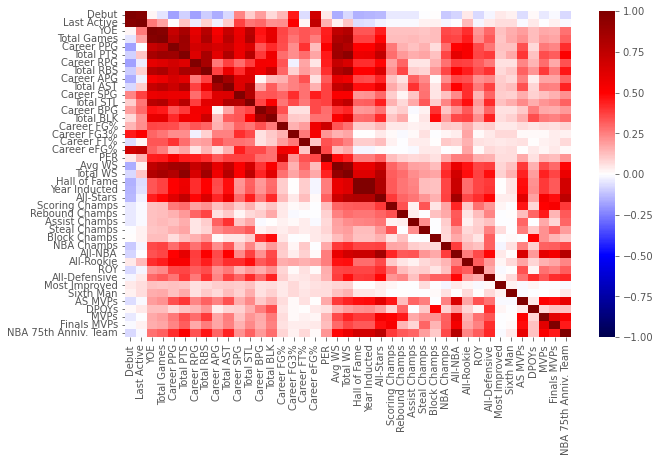

In [13]:
# heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            vmin=-1, vmax=1, cmap='seismic');
plt.show()

In [14]:
# pd.plotting.scatter_matrix(corr, c='b', alpha=0.6, figsize=(15, 10), diagonal='hist');
# plt.show()

In [15]:
#correlation matrix
hof_corr = retired_csv.drop(columns=['Retired','Year Inducted']).corr()['Hall of Fame']
display(hof_corr)

Debut                  -0.149157
Last Active            -0.064425
YOE                     0.333910
Total Games             0.371674
Career PPG              0.501837
Total PTS               0.570240
Career RPG              0.411823
Total RBS               0.504362
Career APG              0.351666
Total AST               0.470663
Career SPG              0.207576
Total STL               0.309200
Career BPG              0.201732
Total BLK               0.286954
Career FG%              0.101187
Career FG3%             0.002064
Career FT%              0.099782
Career eFG%            -0.020563
PER                     0.250434
Avg WS                  0.584681
Total WS                0.625497
Hall of Fame            1.000000
All-Stars               0.810941
Scoring Champs          0.326968
Rebound Champs          0.270707
Assist Champs           0.241844
Steal Champs            0.129620
Block Champs            0.122485
NBA Champs              0.366726
All-NBA                 0.708283
All-Rookie

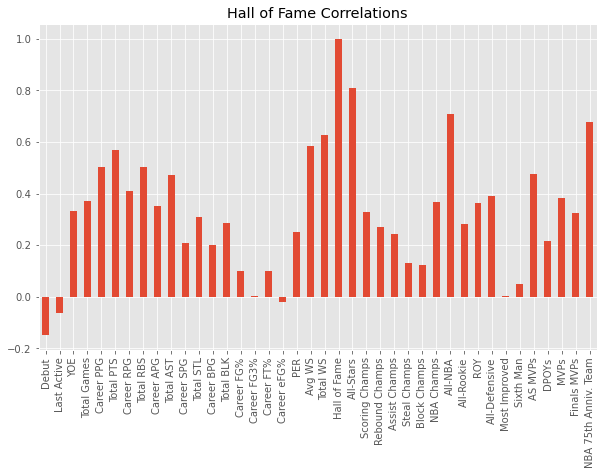

In [16]:
hof_corr.plot.bar()
plt.title('Hall of Fame Correlations')
plt.show()

In [17]:
# we'll also delete Hall of Fame since it directly correlates to itself
remove_key = ['Hall of Fame']

hof_corr_dict = hof_corr.to_dict()
[hof_corr_dict.pop(var) for var in remove_key]

# print(hof_corr_dict)

[1.0]

Lets choose all variables that have a moderate positive correlation; which is anything above 0.30 (nearest 2 decimal points):

In [18]:
predictive_variables = [key for key, value in hof_corr_dict.items() if round(value, 2) >= 0.5]

In [19]:
print(predictive_variables, len(predictive_variables))

['Career PPG', 'Total PTS', 'Total RBS', 'Avg WS', 'Total WS', 'All-Stars', 'All-NBA', 'NBA 75th Anniv. Team'] 8


In [20]:
print(retired_csv.shape)
# we'll only want to train data from those who are officially elligible to enter
retired_hof_eligible = retired_csv[retired_csv['Last Active'] <= 2018].dropna(); print(retired_hof_eligible.shape)
retired_hof_eligible = retired_csv[retired_csv['Last Active'] <= 2018].dropna()

(3552, 45)
(3302, 45)


Lets go ahead and do some predictions:

In [21]:
X, y = retired_hof_eligible[predictive_variables], retired_hof_eligible['Hall of Fame']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [23]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2641, 8) (661, 8) (2641,) (661,)


In [24]:
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

In [25]:
# rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
# for train_index, val_index in rkf.split(X):
#     print("Train:", train_index, "Validation:", val_index)
#     X_train, X_test = X[train_index], X[val_index]
#     y_train, y_test = y[train_index], y[val_index]

# Probabliity Classification

In [26]:
logistic_reg = LogisticRegression().fit(X_train, y_train)

print(metrics.classification_report(y_test, logistic_reg.predict(X_test))); print()
print('Accuracy:', metrics.accuracy_score(y_test, logistic_reg.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, logistic_reg.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, logistic_reg.predict(X_test))); print()
print(metrics.confusion_matrix(y_test, logistic_reg.predict(X_test))); print()
# print(cross_val_score(logistic_reg, X, y, scoring='neg_mean_squared_error', cv=cv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       638
           1       0.88      0.91      0.89        23

    accuracy                           0.99       661
   macro avg       0.94      0.95      0.94       661
weighted avg       0.99      0.99      0.99       661


Accuracy: 0.9924357034795764
Mean Abs Error:  0.007564296520423601
Mean Squared Error:  0.007564296520423601

[[635   3]
 [  2  21]]



In [27]:
# use platt scaling to calibrate and transform into probablity model
svm_model = svm.SVC(kernel='linear', probability=True).fit(X_train, y_train)

print(metrics.classification_report(y_test, svm_model.predict(X_test))); print()
print('Accuracy:', metrics.accuracy_score(y_test, svm_model.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, svm_model.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, svm_model.predict(X_test))); print()
print(metrics.confusion_matrix(y_test, svm_model.predict(X_test))); print()
# print(cross_val_score(svm_model, X, y, scoring='neg_mean_squared_error', cv=cv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       638
           1       1.00      0.87      0.93        23

    accuracy                           1.00       661
   macro avg       1.00      0.93      0.96       661
weighted avg       1.00      1.00      1.00       661


Accuracy: 0.9954614220877458
Mean Abs Error:  0.0045385779122541605
Mean Squared Error:  0.0045385779122541605

[[638   0]
 [  3  20]]



In [28]:
bayes = GaussianNB().fit(X_train, y_train)

print(metrics.classification_report(y_test, bayes.predict(X_test))); print()
print('Accuracy: ', metrics.accuracy_score(y_test, bayes.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, bayes.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, bayes.predict(X_test))); print()
print(metrics.confusion_matrix(y_test, bayes.predict(X_test))); print()
# print(cross_val_score(bayes, X, y, scoring='neg_mean_squared_error', cv=10))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       638
           1       0.41      1.00      0.58        23

    accuracy                           0.95       661
   macro avg       0.71      0.97      0.78       661
weighted avg       0.98      0.95      0.96       661


Accuracy:  0.9500756429652042
Mean Abs Error:  0.049924357034795766
Mean Squared Error:  0.049924357034795766

[[605  33]
 [  0  23]]



# Binary Classification

In [29]:
svm_binary = svm.SVC().fit(X_train, y_train)

print(classification_report(y_test, svm_binary.predict(X_test))); print()
print('Accuracy: ', accuracy_score(y_test, svm_binary.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, svm_binary.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, svm_binary.predict(X_test))); print()
print(confusion_matrix(y_test, svm_binary.predict(X_test))); print()
# print(cross_val_score(svm_binary, X, y, cv=10))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       638
           1       0.59      0.43      0.50        23

    accuracy                           0.97       661
   macro avg       0.78      0.71      0.74       661
weighted avg       0.97      0.97      0.97       661


Accuracy:  0.9697428139183056
Mean Abs Error:  0.030257186081694403
Mean Squared Error:  0.030257186081694403

[[631   7]
 [ 13  10]]



In [30]:
decision_tree = tree.DecisionTreeClassifier(max_depth=15).fit(X_train, y_train)

print(classification_report(y_test, decision_tree.predict(X_test))); print()
print('Accuracy: ', accuracy_score(y_test, decision_tree.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, decision_tree.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, decision_tree.predict(X_test))); print()
print(confusion_matrix(y_test, decision_tree.predict(X_test))); print()
# print(cross_val_score(decision_tree, X, y,scoring='neg_mean_squared_error', cv=10))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       638
           1       0.90      0.83      0.86        23

    accuracy                           0.99       661
   macro avg       0.95      0.91      0.93       661
weighted avg       0.99      0.99      0.99       661


Accuracy:  0.9909228441754917
Mean Abs Error:  0.009077155824508321
Mean Squared Error:  0.009077155824508321

[[636   2]
 [  4  19]]



In [31]:
rand_forest = RandomForestClassifier(n_estimators=1000, max_depth=15).fit(X_train, y_train)

print(classification_report(y_test, rand_forest.predict(X_test))); print()
print('Accuracy: ', accuracy_score(y_test, rand_forest.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, rand_forest.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, rand_forest.predict(X_test))); print()
print(confusion_matrix(y_test, rand_forest.predict(X_test))); print()
# print(cross_val_score(rand_forest, X, y, scoring='neg_mean_squared_error',cv=10))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       638
           1       0.95      0.91      0.93        23

    accuracy                           1.00       661
   macro avg       0.98      0.96      0.97       661
weighted avg       1.00      1.00      1.00       661


Accuracy:  0.9954614220877458
Mean Abs Error:  0.0045385779122541605
Mean Squared Error:  0.0045385779122541605

[[637   1]
 [  2  21]]



In [32]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

print(classification_report(y_test, knn.predict(X_test))); print()
print('Accuracy: ', accuracy_score(y_test, knn.predict(X_test)))
print('Mean Abs Error: ', metrics.mean_absolute_error(y_test, knn.predict(X_test)))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, knn.predict(X_test))); print()
print(confusion_matrix(y_test, knn.predict(X_test))); print()
# print(cross_val_score(knn, X, y, scoring='neg_mean_squared_error', cv=10))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       638
           1       0.55      0.52      0.53        23

    accuracy                           0.97       661
   macro avg       0.76      0.75      0.76       661
weighted avg       0.97      0.97      0.97       661


Accuracy:  0.9682299546142209
Mean Abs Error:  0.03177004538577912
Mean Squared Error:  0.03177004538577912

[[628  10]
 [ 11  12]]



In [33]:
nba_players_hof_prob = all_nba_players

In [34]:
def set_prob(row):
    player = row[predictive_variables]
    hof_probability = svm_model.predict_proba([player]);
    return hof_probability[0][1]

In [35]:
def hof_binary(row):
    player = row[predictive_variables]
    hof_binary = rand_forest.predict([player]);
    return hof_binary[0]

In [36]:
nba_players_hof_prob['HOF Probability'] = nba_players_hof_prob.apply(lambda row: set_prob(row), axis=1)

In [37]:
nba_players_hof_prob['HOF (Y/N)'] = nba_players_hof_prob.apply(lambda row: hof_binary(row), axis=1)

In [38]:
nba_players_hof_prob_to_csv = nba_players_hof_prob[['Player','Debut','Last Active','YOE','Position',
                                   'Team','Hall of Fame','HOF Probability','HOF (Y/N)']]

In [39]:
display(nba_players_hof_prob_to_csv)

,Player,Debut,Last Active,YOE,Position,Team,Hall of Fame,HOF Probability,HOF (Y/N)
0,Alaa Abdelnaby,1990,1995,5,PF,POR,0,0.000468,0
1,Zaid Abdul-Aziz,1968,1978,10,C,HOU,0,0.001658,0
2,Kareem Abdul-Jabbar,1969,1989,20,C,LAL,1,1.000000,1
3,Mahmoud Abdul-Rauf,1990,2001,9,PG,DEN,0,0.003256,0
4,Tariq Abdul-Wahad,1997,2003,6,SG,DEN,0,0.000743,0
...,...,...,...,...,...,...,...,...,...
4392,Paul Zipser,2016,2018,2,SF,CHI,0,0.000296,0
4393,Ante Žižić,2017,2020,3,C,CLE,0,0.000583,0
4394,Jim Zoet,1982,1983,1,C,DET,0,0.000078,0
4395,Bill Zopf,1970,1971,1,PG,MIL,0,0.000139,0


In [40]:
nba_players_hof_prob_to_csv.to_csv('csv_files/nba_players_hof_prob.csv', index=False)

In [41]:
hof_players.to_csv('csv_files/hof_players_prob.csv', index=False)

In [42]:
nba_players_hof_prob = nba_players_hof_prob.dropna()

In [43]:
nba_players_hof_prob.to_csv('csv_files/nba_players_hof_prob_with_stats.csv', index=False)

In [44]:
nba_players_hof_prob = pd.read_csv('csv_files/nba_players_hof_prob_with_stats.csv')

In [54]:
last_active = 2019; year_inducted = last_active+4

# predict 2022 hall of fame inductees
hof_prob = nba_players_hof_prob.sort_values(by='HOF Probability', ascending=False)

# get all retired players
retired_non_hof = hof_prob[(hof_prob['Last Active'] <= last_active) &
                                    (hof_prob['Retired'] == 1) &
                                  (hof_prob['Hall of Fame'] == 0) |
                                 (hof_prob['Year Inducted'] == year_inducted) &
                                 (hof_prob['Hall of Fame'] == 1)]

In [55]:
# lets grab the only columns we need
retired_non_hof = retired_non_hof[['Player','Debut','Last Active','YOE','Position',
                                   'Team','HOF Probability','HOF (Y/N)']]
hof_players_prob = hof_prob[['Player','Debut','Last Active','YOE','Position',
                                   'Team','HOF Probability','HOF (Y/N)','Year Inducted']]

display(retired_non_hof.head(15))

display(retired_non_hof[retired_non_hof['HOF (Y/N)'] == 1])
print(retired_non_hof.shape)

display(hof_players_prob[hof_players_prob['Year Inducted'] == year_inducted])
print(hof_players.shape)

,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N)
2757,Dirk Nowitzki,1998,2019,21,PF,DAL,1.000000,1
3816,Dwyane Wade,2003,2019,16,SG,MIA,1.000000,1
1273,Pau Gasol,2001,2019,18,C,MEM,0.957843,1
3548,Amar'e Stoudemire,2002,2016,14,PF,PHO,0.954783,0
1191,Larry Foust,1950,1962,12,C,DET,0.943571,0
1892,Marques Johnson,1977,1990,11,SF,MIL,0.883364,0
837,Brad Daugherty,1986,1994,8,C,CLE,0.842317,0
2004,Shawn Kemp,1989,2003,14,PF,OKC,0.800178,0
1886,Kevin Johnson,1987,2000,12,PG,PHO,0.686202,0
298,Chauncey Billups,1997,2014,17,PG,DET,0.652700,0


,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N)
2757,Dirk Nowitzki,1998,2019,21,PF,DAL,1.000000,1
3816,Dwyane Wade,2003,2019,16,SG,MIA,1.000000,1
1273,Pau Gasol,2001,2019,18,C,MEM,0.957843,1
2868,Tony Parker,2001,2019,18,PG,SAS,0.650820,1
4167,Max Zaslofsky,1946,1956,10,SG,CHS,0.073418,1


(3194, 8)


,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N),Year Inducted


(130, 45)


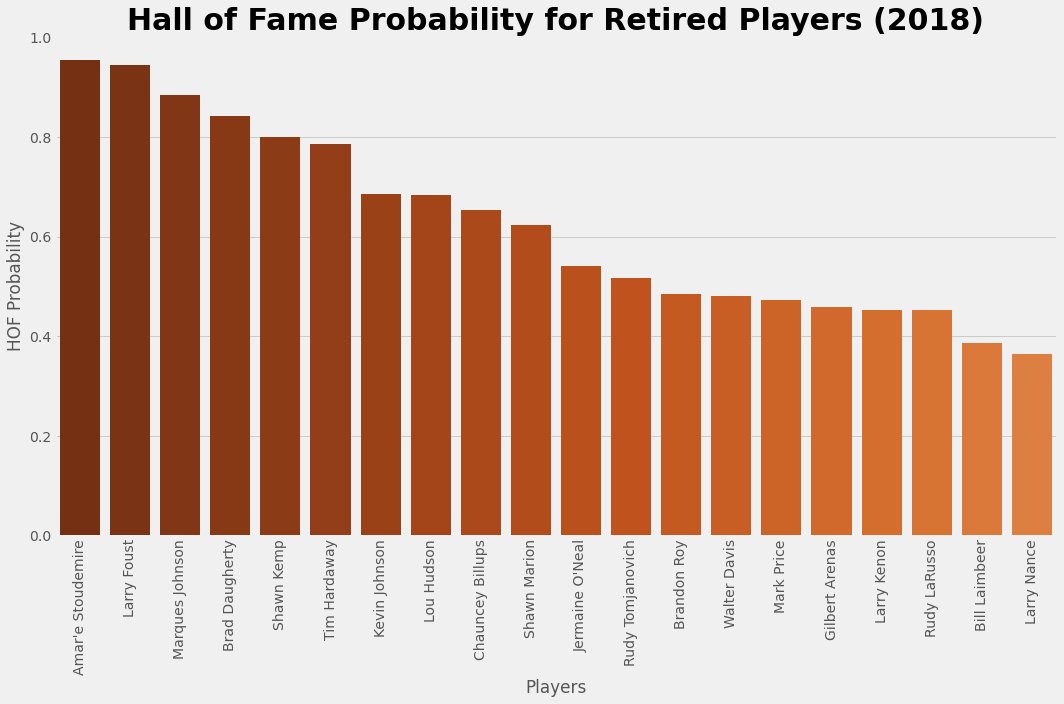

In [47]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,10))

ax = sns.barplot(x='Player', y='HOF Probability', data=retired_non_hof[:20], 
                                             palette=sns.color_palette("Oranges_r", len(retired_non_hof[:45])))
ax.set_xticklabels(retired_non_hof['Player'][:20], rotation=90)
ax.set(xlabel='Players', ylabel='HOF Probability')
plt.title('Hall of Fame Probability for Retired Players (2018)', fontsize=30, fontweight='bold')

plt.tight_layout()
plt.savefig('images/2022_hof_prob.png')

In [48]:
# predict active inductees
active_players = nba_players_hof_prob.sort_values(by='HOF Probability', ascending=False)

# get all retired players
active_players = active_players[(active_players['Last Active'] == 2022) |
                               (active_players['Retired'] == 0)]

In [49]:
# lets grab the only columns we need
active_players = active_players[['Player','Debut','Last Active','YOE','Position',
                                   'Team','HOF Probability','HOF (Y/N)']]

display(active_players.head(50))
print(active_players.shape)

,Player,Debut,Last Active,YOE,Position,Team,HOF Probability,HOF (Y/N)
1806,LeBron James,2003,2022,19,SF,CLE,1.000000,1
1012,Kevin Durant,2007,2022,14,SF,OKC,1.000000,1
2885,Chris Paul,2005,2022,17,PG,NOP,1.000000,1
1496,James Harden,2009,2022,13,SG,HOU,1.000000,1
3937,Russell Westbrook,2008,2022,14,PG,OKC,0.999998,1
818,Stephen Curry,2009,2022,13,PG,GSW,0.999996,1
842,Anthony Davis,2012,2022,10,PF,NOP,0.999995,1
1697,Dwight Howard,2004,2022,18,C,ORL,0.999992,1
110,Carmelo Anthony,2003,2022,19,SF,DEN,0.994167,1
2213,Damian Lillard,2012,2022,10,PG,POR,0.993472,1


(845, 8)


In [50]:
nba_players_hof_prob_to_csv = nba_players_hof_prob_to_csv.sort_values(by='HOF Probability', ascending=False)
display(nba_players_hof_prob_to_csv.head(100))

,Player,Debut,Last Active,YOE,Position,Team,Hall of Fame,HOF Probability,HOF (Y/N)
2,Kareem Abdul-Jabbar,1969,1989,20,C,LAL,1,1.000000,1
1899,LeBron James,2003,2022,19,SF,CLE,0,1.000000,1
665,Wilt Chamberlain,1959,1973,14,C,GSW,1,1.000000,1
1057,Tim Duncan,1997,2016,19,C,SAS,1,1.000000,1
529,Kobe Bryant,1996,2016,20,SG,LAL,1,1.000000,1
2911,Shaquille O'Neal,1992,2011,19,C,LAL,1,1.000000,1
2067,Michael Jordan,1984,2003,15,SG,CHI,1,1.000000,1
2420,Karl Malone,1985,2004,19,PF,UTA,1,1.000000,1
4139,Jerry West,1960,1974,14,PG,LAL,1,1.000000,1
3401,Bill Russell,1956,1969,13,C,BOS,1,1.000000,1


In [53]:
display(nba_players_hof_prob_to_csv[nba_players_hof_prob_to_csv['HOF (Y/N)'] == 0].head(25))

,Player,Debut,Last Active,YOE,Position,Team,Hall of Fame,HOF Probability,HOF (Y/N)
3739,Amar'e Stoudemire,2002,2016,14,PF,PHO,0,0.954783,0
1254,Larry Foust,1950,1962,12,C,DET,0,0.943571,0
1502,Alex Groza,1949,1951,2,NaN,INO,0,0.912299,0
999,Luka Dončić,2018,2022,4,PG,DAL,0,0.905922,0
1986,Marques Johnson,1977,1990,11,SF,MIL,0,0.883364,0
879,Brad Daugherty,1986,1994,8,C,CLE,0,0.842317,0
3908,Karl-Anthony Towns,2015,2022,7,C,MIN,0,0.839981,0
2100,Shawn Kemp,1989,2003,14,PF,OKC,0,0.800178,0
1980,Kevin Johnson,1987,2000,12,PG,PHO,0,0.686202,0
315,Chauncey Billups,1997,2014,17,PG,DET,0,0.652700,0


In [52]:
display(nba_players_hof_prob_to_csv[(nba_players_hof_prob_to_csv['HOF (Y/N)'] == 0) &
                                   (nba_players_hof_prob_to_csv['Hall of Fame'] == 1)].head())

display(nba_players_hof_prob_to_csv[(nba_players_hof_prob_to_csv['Last Active'] <= 2018) &
                                   (nba_players_hof_prob_to_csv['HOF (Y/N)'] == 1) &
                                   (nba_players_hof_prob_to_csv['Hall of Fame'] == 0)].head())

display(nba_players_hof_prob_to_csv[(nba_players_hof_prob_to_csv['Last Active'] <= 2018) &
                                   (nba_players_hof_prob_to_csv['HOF (Y/N)'] == 0) &
                                   (nba_players_hof_prob_to_csv['Hall of Fame'] == 0) &
                                   (nba_players_hof_prob_to_csv['HOF Probability'] >= 0.5)].head())

,Player,Debut,Last Active,YOE,Position,Team,Hall of Fame,HOF Probability,HOF (Y/N)
2361,Clyde Lovellette,1953,1964,11,C,LAL,1,0.500000,0
444,Carl Braun,1947,1962,13,PG,NYK,1,0.298117,0


,Player,Debut,Last Active,YOE,Position,Team,Hall of Fame,HOF Probability,HOF (Y/N)
4379,Max Zaslofsky,1946,1956,10,SG,CHS,0,0.073418,1


,Player,Debut,Last Active,YOE,Position,Team,Hall of Fame,HOF Probability,HOF (Y/N)
3739,Amar'e Stoudemire,2002,2016,14,PF,PHO,0,0.954783,0
1254,Larry Foust,1950,1962,12,C,DET,0,0.943571,0
1502,Alex Groza,1949,1951,2,NaN,INO,0,0.912299,0
1986,Marques Johnson,1977,1990,11,SF,MIL,0,0.883364,0
879,Brad Daugherty,1986,1994,8,C,CLE,0,0.842317,0
